New logic: Swire would want to predict the abandonment couple of days before the end of the window. 
Fit training data with cart abandonment but only up to the last 2 windows of puchase or abandon. 
Then for the test data, test/predict only couples days in not wait untill the end of the window. 

In [118]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_validate
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder


from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer


# from lightgbm import LGBMClassifier
# import xgboost as xgb
# from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
import seaborn as sns


# Clean google analytics.csv and join with customer.csv 


In [119]:
ga = pd.read_csv("Copy of google_analytics.csv")
pd.set_option('display.max_columns', None)
ga.head()

,CUSTOMER_ID,EVENT_DATE,EVENT_TIMESTAMP,EVENT_NAME,DEVICE_CATEGORY,DEVICE_MOBILE_BRAND_NAME,DEVICE_OPERATING_SYSTEM,EVENT_PAGE_NAME,EVENT_PAGE_TITLE,ITEMS
0,501508595,2025-04-07,2025-04-07T14:57:40.713Z,view_search_results,mobile,Samsung,Android,Product List,NaN,[]
1,501730915,2025-04-07,2025-04-07T19:28:54.546Z,view_item_list,desktop,Google,Windows,NaN,Search,"[{""item_id"":""158520"",""quantity"":""1""},{""item_id..."
2,501567329,2025-04-07,2025-04-07T21:40:56.281Z,purchase,desktop,Google,Windows,MyCoke Orders - Purchase Success,Order,"[{""item_id"":""138335"",""quantity"":""2""},{""item_id..."
3,501765083,2025-04-08,2025-04-08T06:06:36.717Z,user_engagement,mobile,Apple,iOS,NaN,NaN,[]
4,501707837,2025-04-08,2025-04-08T18:12:10.511Z,view_item_list,desktop,Google,Windows,MyCoke Orders,Category: All Products,"[{""item_id"":""412588"",""quantity"":""1""},{""item_id..."


In [120]:
# Getting only cart affected events
ga_cart_events = ga[ga['EVENT_NAME'].isin(['add_to_cart', 'remove_from_cart','purchase'])]

In [121]:
# Join customer.csv with ga_cart_events to get customer's local time 
customer = pd.read_csv('Copy of customer.csv')

customer_ga_cart_events = pd.merge(ga_cart_events, customer, left_on='CUSTOMER_ID', right_on='CUSTOMER_NUMBER', how='left')

In [122]:
from zoneinfo import ZoneInfo
import pandas as pd

# ---- 1) City → timezone map (as you had) ----
city_tz = {
    "Tacoma, WA":"America/Los_Angeles","Spokane, WA":"America/Los_Angeles",
    "Arlington, WA":"America/Los_Angeles","Bellevue, WA":"America/Los_Angeles",
    "Walla Walla, WA":"America/Los_Angeles","Reno, NV":"America/Los_Angeles",
    "Elko, NV":"America/Los_Angeles","Pendleton, OR":"America/Los_Angeles",
    "Eugene, OR":"America/Los_Angeles","Wilsonville, OR":"America/Los_Angeles",
    "Bend, OR":"America/Los_Angeles","LaGrande, OR":"America/Los_Angeles",
    "Lewiston, ID":"America/Los_Angeles","Wenatchee, WA":"America/Los_Angeles",
    "Bremerton, WA":"America/Los_Angeles",
    "Denver, CO":"America/Denver","Colorado Springs, CO":"America/Denver",
    "Grand Junction, CO":"America/Denver","Glenwood Springs, CO":"America/Denver",
    "Pueblo, CO":"America/Denver","Alamosa, CO":"America/Denver",
    "Johnstown, CO":"America/Denver","Cheyenne, WY":"America/Denver",
    "Richfield, UT":"America/Denver","Draper, UT":"America/Denver",
    "Logan, UT":"America/Denver","Ogden, UT":"America/Denver",
    "Price, UT":"America/Denver","Albuquerque, NM":"America/Denver",
    "Scottsbluff, NE":"America/Denver",
    "Boise, ID":"America/Boise","Idaho Falls, ID":"America/Boise","Pocatello, ID":"America/Boise",
    "Tempe, AZ":"America/Phoenix","Tucson, AZ":"America/Phoenix",
    "Prescott, AZ":"America/Phoenix","Glendale, AZ":"America/Phoenix",
    "Kingman, AZ":"America/Phoenix","Huachuca City, AZ":"America/Phoenix",
    "Show Low, AZ":"America/Phoenix","Flagstaff, AZ":"America/Phoenix",
    "Yuma, AZ":"America/Phoenix",
}

# ---- 2) Parse timestamp as UTC (kept your column name) ----
customer_ga_cart_events["EVENT_TIMESTAMP_UTC"] = pd.to_datetime(
    customer_ga_cart_events["EVENT_TIMESTAMP"], utc=True, errors="coerce"
)

# ---- 3) Map timezone from CITY (use CITY consistently) ----
customer_ga_cart_events["TIMEZONE"] = customer_ga_cart_events["SALES_OFFICE_DESCRIPTION"].map(city_tz)

# ---- 4) Convert to local datetime per-row (only when TIMEZONE present) ----
customer_ga_cart_events["EVENT_LOCAL_DT"] = customer_ga_cart_events.apply(
    lambda row: (
        row["EVENT_TIMESTAMP_UTC"].astimezone(ZoneInfo(row["TIMEZONE"]))
        if pd.notna(row["TIMEZONE"]) and pd.notna(row["EVENT_TIMESTAMP_UTC"])
        else pd.NaT
    ),
    axis=1
)

# ---- 5) Convenience columns: date / hour / day-of-week ----
customer_ga_cart_events["EVENT_LOCAL_DATE"] = customer_ga_cart_events["EVENT_LOCAL_DT"].apply(
    lambda v: v.date() if pd.notna(v) else pd.NaT
)
customer_ga_cart_events["EVENT_LOCAL_TIME"] = customer_ga_cart_events["EVENT_LOCAL_DT"].apply(
    lambda v: v.strftime("%I:%M:%S %p") if pd.notna(v) else pd.NA
)
customer_ga_cart_events["EVENT_LOCAL_DOW"] = customer_ga_cart_events["EVENT_LOCAL_DT"].apply(
    lambda v: v.day_name() if pd.notna(v) else pd.NA
)

# ---- 6) Drop duplicates (use the actual UTC column name) ----
customer_ga_cart_events = customer_ga_cart_events.drop_duplicates(
    subset=["CUSTOMER_ID","EVENT_TIMESTAMP_UTC","EVENT_NAME"],
    keep="first"
)

# ---- 7) Select relevant columns (use consistent names) ----
cols = [
    "CUSTOMER_ID","CITY","TIMEZONE","EVENT_NAME",
    "EVENT_LOCAL_TIME","EVENT_LOCAL_DT","EVENT_LOCAL_DATE",
    "EVENT_LOCAL_HOUR","EVENT_LOCAL_DOW",
    "DEVICE_CATEGORY","DEVICE_MOBILE_BRAND_NAME","DEVICE_OPERATING_SYSTEM",
    "EVENT_PAGE_NAME","EVENT_PAGE_TITLE"
]
existing_cols = [c for c in cols if c in customer_ga_cart_events.columns]
customer_ga_cart_events = customer_ga_cart_events[existing_cols]

customer_ga_cart_events.head()


,CUSTOMER_ID,TIMEZONE,EVENT_NAME,EVENT_LOCAL_TIME,EVENT_LOCAL_DT,EVENT_LOCAL_DATE,EVENT_LOCAL_DOW,DEVICE_CATEGORY,DEVICE_MOBILE_BRAND_NAME,DEVICE_OPERATING_SYSTEM,EVENT_PAGE_NAME,EVENT_PAGE_TITLE
0,501567329,America/Los_Angeles,purchase,02:40:56 PM,2025-04-07 14:40:56.281000-07:00,2025-04-07,Monday,desktop,Google,Windows,MyCoke Orders - Purchase Success,Order
1,501702910,America/Denver,add_to_cart,12:30:14 PM,2025-05-24 12:30:14.025000-06:00,2025-05-24,Saturday,desktop,Google,Windows,NaN,Search
2,501565777,America/Phoenix,add_to_cart,01:08:07 PM,2025-05-20 13:08:07.167000-07:00,2025-05-20,Tuesday,mobile,Samsung,Android,NaN,Search
3,501752380,America/Los_Angeles,add_to_cart,02:25:29 PM,2025-05-16 14:25:29.494000-07:00,2025-05-16,Friday,desktop,Apple,Macintosh,NaN,Search
4,500549947,America/Los_Angeles,add_to_cart,06:12:45 PM,2025-04-07 18:12:45.609000-07:00,2025-04-07,Monday,mobile,Apple,iOS,Product List,NaN


# The windows from master.csv

In [123]:
windows = pd.read_csv('master.csv')

In [124]:
windows.columns

Index(['Unnamed: 0', 'CUSTOMER_ID', 'ANCHOR_DATE', 'SALES_OFFICE_x',
       'SHIPPING_CONDITIONS_DESC', 'WEEK_DAY_OF_ANCHOR_DATE',
       'WINDOW_FREQUENCY', 'DISTRIBUTION_MODE_DESC', 'CUTOFFTIME__C',
       'NEXT_ANCHOR_SAME_WD'],
      dtype='object')

In [125]:
pd.set_option('display.max_columns', None)

windows.head(20)

,Unnamed: 0,CUSTOMER_ID,ANCHOR_DATE,SALES_OFFICE_x,SHIPPING_CONDITIONS_DESC,WEEK_DAY_OF_ANCHOR_DATE,WINDOW_FREQUENCY,DISTRIBUTION_MODE_DESC,CUTOFFTIME__C,NEXT_ANCHOR_SAME_WD
0,219,500245685,2024-06-10,G111,48 Hours,Monday,7,OFS,5:00:00 PM,2024-06-17
1,220,500245685,2024-06-17,G111,48 Hours,Monday,7,OFS,5:00:00 PM,2024-06-24
2,221,500245685,2024-06-24,G111,48 Hours,Monday,7,OFS,5:00:00 PM,2024-07-01
3,222,500245685,2024-07-01,G111,48 Hours,Monday,7,OFS,5:00:00 PM,2024-07-08
4,223,500245685,2024-07-08,G111,48 Hours,Monday,7,OFS,5:00:00 PM,2024-07-15
5,224,500245685,2024-07-15,G111,48 Hours,Monday,7,OFS,5:00:00 PM,2024-07-22
6,225,500245685,2024-07-22,G111,48 Hours,Monday,7,OFS,5:00:00 PM,2024-07-29
7,226,500245685,2024-07-29,G111,48 Hours,Monday,7,OFS,5:00:00 PM,2024-08-05
8,227,500245685,2024-08-05,G111,48 Hours,Monday,7,OFS,5:00:00 PM,2024-08-12
9,228,500245685,2024-08-12,G111,48 Hours,Monday,7,OFS,5:00:00 PM,2024-08-19


# windows join customer_ga_cart_events

Join exploded windows to Google Analytics, with cart events only.

Left merge from windows and filter for correct dates of GA within windows. 

In [126]:
# Ensure datetime types
windows["ANCHOR_DATE"] = pd.to_datetime(windows["ANCHOR_DATE"])
windows["NEXT_ANCHOR_SAME_WD"] = pd.to_datetime(windows["NEXT_ANCHOR_SAME_WD"])
customer_ga_cart_events["EVENT_LOCAL_DATE"] = pd.to_datetime(customer_ga_cart_events["EVENT_LOCAL_DATE"])

# Perform a LEFT merge (windows = left table)
windows_with_ga = pd.merge(
    windows,
    customer_ga_cart_events,
    on="CUSTOMER_ID",
    how="left"
)


windows_with_ga["WINDOW_START_LOCAL"] = pd.to_datetime(
    windows_with_ga["ANCHOR_DATE"].dt.strftime("%Y-%m-%d") + " " + windows_with_ga['CUTOFFTIME__C'],   #CUTOFFTIME__C	?
    errors="coerce"
)
windows_with_ga["WINDOW_END_LOCAL"] = pd.to_datetime(
    windows_with_ga["NEXT_ANCHOR_SAME_WD"].dt.strftime("%Y-%m-%d") + " " + windows_with_ga['CUTOFFTIME__C'],
    errors="coerce"
)

# 2) Drop timezone from the event’s local datetime so it’s naive too
windows_with_ga["EVENT_LOCAL_NAIVE"] = windows_with_ga["EVENT_LOCAL_DT"].apply(
    lambda v: pd.NaT if pd.isna(v) else pd.Timestamp(v).tz_localize(None)
)

# 1) Build in-window mask (compare naive-to-naive)
in_window = (
    (windows_with_ga["EVENT_LOCAL_NAIVE"] >= windows_with_ga["WINDOW_START_LOCAL"]) &
    (windows_with_ga["EVENT_LOCAL_NAIVE"] <  windows_with_ga["WINDOW_END_LOCAL"])
)

windows_with_ga = windows_with_ga[in_window].copy()





/var/folders/hd/fbf93pws5pn1ycb22tw5k1240000gn/T/ipykernel_30798/281581639.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  windows_with_ga["WINDOW_START_LOCAL"] = pd.to_datetime(
/var/folders/hd/fbf93pws5pn1ycb22tw5k1240000gn/T/ipykernel_30798/281581639.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  windows_with_ga["WINDOW_END_LOCAL"] = pd.to_datetime(


This is all the GA cart events for each windows. Each windows migh have many events (unaggreagated)

In [127]:
windows_with_ga[windows_with_ga['CUSTOMER_ID']==501730915]

,Unnamed: 0,CUSTOMER_ID,ANCHOR_DATE,SALES_OFFICE_x,SHIPPING_CONDITIONS_DESC,WEEK_DAY_OF_ANCHOR_DATE,WINDOW_FREQUENCY,DISTRIBUTION_MODE_DESC,CUTOFFTIME__C,NEXT_ANCHOR_SAME_WD,TIMEZONE,EVENT_NAME,EVENT_LOCAL_TIME,EVENT_LOCAL_DT,EVENT_LOCAL_DATE,EVENT_LOCAL_DOW,DEVICE_CATEGORY,DEVICE_MOBILE_BRAND_NAME,DEVICE_OPERATING_SYSTEM,EVENT_PAGE_NAME,EVENT_PAGE_TITLE,WINDOW_START_LOCAL,WINDOW_END_LOCAL,EVENT_LOCAL_NAIVE
6916472,975640,501730915,2024-11-14,G141,48 Hours,Thursday,7,Sideload,3:00:00 PM,2024-11-21,America/Boise,add_to_cart,08:47:12 AM,2024-11-18 08:47:12.263000-07:00,2024-11-18,Monday,desktop,Microsoft,Windows,NaN,Category: All Products,2024-11-14 15:00:00,2024-11-21 15:00:00,2024-11-18 08:47:12.263
6916474,975640,501730915,2024-11-14,G141,48 Hours,Thursday,7,Sideload,3:00:00 PM,2024-11-21,America/Boise,add_to_cart,08:49:59 AM,2024-11-18 08:49:59.113000-07:00,2024-11-18,Monday,desktop,Microsoft,Windows,MyCoke Orders,Category: All Products,2024-11-14 15:00:00,2024-11-21 15:00:00,2024-11-18 08:49:59.113
6916478,975640,501730915,2024-11-14,G141,48 Hours,Thursday,7,Sideload,3:00:00 PM,2024-11-21,America/Boise,add_to_cart,08:47:45 AM,2024-11-18 08:47:45.663000-07:00,2024-11-18,Monday,desktop,Microsoft,Windows,NaN,Category: All Products,2024-11-14 15:00:00,2024-11-21 15:00:00,2024-11-18 08:47:45.663
6916486,975640,501730915,2024-11-14,G141,48 Hours,Thursday,7,Sideload,3:00:00 PM,2024-11-21,America/Boise,add_to_cart,08:54:16 AM,2024-11-18 08:54:16.470000-07:00,2024-11-18,Monday,desktop,Microsoft,Windows,MyCoke Orders,Category: All Products,2024-11-14 15:00:00,2024-11-21 15:00:00,2024-11-18 08:54:16.470
6916496,975640,501730915,2024-11-14,G141,48 Hours,Thursday,7,Sideload,3:00:00 PM,2024-11-21,America/Boise,purchase,08:56:09 AM,2024-11-18 08:56:09.930000-07:00,2024-11-18,Monday,desktop,Microsoft,Windows,MyCoke Orders - Purchase Success,Order,2024-11-14 15:00:00,2024-11-21 15:00:00,2024-11-18 08:56:09.930
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6918617,975665,501730915,2025-05-08,G141,48 Hours,Thursday,7,OFS,3:00:00 PM,2025-05-15,America/Boise,purchase,02:00:11 PM,2025-05-12 14:00:11.669000-06:00,2025-05-12,Monday,desktop,Google,Windows,MyCoke Orders - Purchase Success,Order,2025-05-08 15:00:00,2025-05-15 15:00:00,2025-05-12 14:00:11.669
6918627,975665,501730915,2025-05-08,G141,48 Hours,Thursday,7,OFS,3:00:00 PM,2025-05-15,America/Boise,add_to_cart,01:59:19 PM,2025-05-12 13:59:19.895000-06:00,2025-05-12,Monday,desktop,Google,Windows,MyCoke Orders - Product:,Category: Energy Drinks,2025-05-08 15:00:00,2025-05-15 15:00:00,2025-05-12 13:59:19.895
6918633,975665,501730915,2025-05-08,G141,48 Hours,Thursday,7,OFS,3:00:00 PM,2025-05-15,America/Boise,add_to_cart,01:58:44 PM,2025-05-12 13:58:44.112000-06:00,2025-05-12,Monday,desktop,Google,Windows,MyCoke Order Builder,Order Builder,2025-05-08 15:00:00,2025-05-15 15:00:00,2025-05-12 13:58:44.112
6918727,975666,501730915,2025-05-15,G141,48 Hours,Thursday,7,OFS,3:00:00 PM,2025-05-22,America/Boise,add_to_cart,09:06:00 PM,2025-05-19 21:06:00.765000-06:00,2025-05-19,Monday,desktop,Google,Windows,MyCoke Order Builder,Order Builder,2025-05-15 15:00:00,2025-05-22 15:00:00,2025-05-19 21:06:00.765


# New logic for GA cutoff date

Add a new cutoff date for the Predictive model, per each frequency

In [128]:
windows_with_ga1=windows_with_ga.copy()
# What are the top frequencies for customers
windows_with_ga1.groupby('WINDOW_FREQUENCY')['CUSTOMER_ID'].nunique()


WINDOW_FREQUENCY
7     3029
14    1140
21      17
28    1469
Name: CUSTOMER_ID, dtype: int64

In [129]:
# Frequency cutoff change as needed
frequency_cutoff = {
    7:2,       
    14:4,
    21:7,
    28:10}

#New column
windows_with_ga1["event_cutoff_days"] = windows_with_ga1["WINDOW_FREQUENCY"].map(frequency_cutoff)


The problem, cutted off the purchase events by the days above. If we want to use cart activities - of todays, we need the target of tomorrows, not today. 

Change all WINDOW_END_LOCAL_event_cutoff = TRUE where EVENT_NAME = purchase. 

Then make 2 columns of purchase, purchase before and after event cutoff. 

If purchase before = True, delete row (already purchase, no need to predict)
If purchase after = TRUE then 0, not then 1. This will be the target variable

This way, if customer have cart activities before frequency cutoff and not yet purchase before it, then our model could predict if they are going to purchase or not. 

In the presentation, mention how much data we excluded because of our choice of event cutoff date. 

In [130]:
windows_with_ga1["WINDOW_END_LOCAL_event_cutoff"] = (
    windows_with_ga1["WINDOW_END_LOCAL"]
    - pd.to_timedelta(windows_with_ga1["event_cutoff_days"], unit="D") 
)


In [131]:
#Flag EVENT_LOCAL_NAIVE not within WINDOW_START_LOCAL - WINDOW_END_LOCAL_event_cutoff or EVENT_NAME == purchase
windows_with_ga1['event_within_new_cutoff_purchase'] = (
    (windows_with_ga1['EVENT_LOCAL_NAIVE'] <= windows_with_ga1['WINDOW_END_LOCAL_event_cutoff']) |
    (windows_with_ga1['EVENT_NAME'] == 'purchase')
)



In [132]:
# We have both purchase after and before event cutoff
windows_with_ga1[(windows_with_ga1['EVENT_NAME']=='purchase') & 
                 (windows_with_ga1['EVENT_LOCAL_NAIVE'] > windows_with_ga1['WINDOW_END_LOCAL_event_cutoff'])].head()

,Unnamed: 0,CUSTOMER_ID,ANCHOR_DATE,SALES_OFFICE_x,SHIPPING_CONDITIONS_DESC,WEEK_DAY_OF_ANCHOR_DATE,WINDOW_FREQUENCY,DISTRIBUTION_MODE_DESC,CUTOFFTIME__C,NEXT_ANCHOR_SAME_WD,TIMEZONE,EVENT_NAME,EVENT_LOCAL_TIME,EVENT_LOCAL_DT,EVENT_LOCAL_DATE,EVENT_LOCAL_DOW,DEVICE_CATEGORY,DEVICE_MOBILE_BRAND_NAME,DEVICE_OPERATING_SYSTEM,EVENT_PAGE_NAME,EVENT_PAGE_TITLE,WINDOW_START_LOCAL,WINDOW_END_LOCAL,EVENT_LOCAL_NAIVE,event_cutoff_days,WINDOW_END_LOCAL_event_cutoff,event_within_new_cutoff_purchase
1812,5275,500245738,2024-07-19,G111,24 Hours,Friday,7,OFS,3:30:00 PM,2024-07-26,America/Denver,purchase,11:42:26 AM,2024-07-26 11:42:26.724000-06:00,2024-07-26,Friday,desktop,Microsoft,Windows,MyCoke Orders - Purchase Success,Checkout,2024-07-19 15:30:00,2024-07-26 15:30:00,2024-07-26 11:42:26.724,2,2024-07-24 15:30:00,True
2106,5277,500245738,2024-08-02,G111,24 Hours,Friday,7,OFS,3:30:00 PM,2024-08-09,America/Denver,purchase,04:54:38 PM,2024-08-07 16:54:38.600000-06:00,2024-08-07,Wednesday,desktop,Microsoft,Windows,MyCoke Orders - Purchase Success,Checkout,2024-08-02 15:30:00,2024-08-09 15:30:00,2024-08-07 16:54:38.600,2,2024-08-07 15:30:00,True
2306,5278,500245738,2024-08-09,G111,24 Hours,Friday,7,OFS,3:30:00 PM,2024-08-16,America/Denver,purchase,03:25:05 PM,2024-08-16 15:25:05.444000-06:00,2024-08-16,Friday,desktop,Microsoft,Windows,MyCoke Orders - Purchase Success,Checkout,2024-08-09 15:30:00,2024-08-16 15:30:00,2024-08-16 15:25:05.444,2,2024-08-14 15:30:00,True
2353,5278,500245738,2024-08-09,G111,24 Hours,Friday,7,OFS,3:30:00 PM,2024-08-16,America/Denver,purchase,03:47:39 PM,2024-08-14 15:47:39.347000-06:00,2024-08-14,Wednesday,desktop,Microsoft,Windows,MyCoke Orders - Purchase Success,Checkout,2024-08-09 15:30:00,2024-08-16 15:30:00,2024-08-14 15:47:39.347,2,2024-08-14 15:30:00,True
2439,5279,500245738,2024-08-16,G111,24 Hours,Friday,7,OFS,3:30:00 PM,2024-08-23,America/Denver,purchase,12:48:24 PM,2024-08-23 12:48:24.338000-06:00,2024-08-23,Friday,desktop,Microsoft,Windows,MyCoke Orders - Purchase Success,Checkout,2024-08-16 15:30:00,2024-08-23 15:30:00,2024-08-23 12:48:24.338,2,2024-08-21 15:30:00,True


In [133]:
# Which window have high cutoff rate, so we could tweak the dict above
freq_cutoff_summary = (
    windows_with_ga1
    .groupby("WINDOW_FREQUENCY")["event_within_new_cutoff_purchase"]
    .mean()
    .sort_values(ascending=False)
)
print(freq_cutoff_summary)
print(f'Total len before cutoff for new logic {len(windows_with_ga1)}')


WINDOW_FREQUENCY
7     0.787869
21    0.758621
14    0.660491
28    0.599018
Name: event_within_new_cutoff_purchase, dtype: float64
Total len before cutoff for new logic 249148


In [134]:
#Get rows of data that the events are within the new cutoff date
windows_with_ga1 = windows_with_ga1[windows_with_ga1['event_within_new_cutoff_purchase']==True]
print(f'Total len after cutoff {len(windows_with_ga1)}')

Total len after cutoff 184314


# Aggregation

In [135]:
# Add events count before aggregations
windows_with_ga1["add_to_cart_count"] = (windows_with_ga1["EVENT_NAME"] == "add_to_cart").astype("int")
windows_with_ga1["remove_from_cart_count"] = (windows_with_ga1["EVENT_NAME"] == "remove_from_cart").astype("int")


windows_with_ga1["purchase_before_event_cutoff_count"] = ((windows_with_ga1['EVENT_NAME']=='purchase') & 
                                                                          (windows_with_ga1['EVENT_LOCAL_NAIVE'] <= windows_with_ga1['WINDOW_END_LOCAL_event_cutoff']))
windows_with_ga1["purchase_after_event_cutoff_count"] = ((windows_with_ga1['EVENT_NAME']=='purchase') & 
                                                                          (windows_with_ga1['EVENT_LOCAL_NAIVE'] > windows_with_ga1['WINDOW_END_LOCAL_event_cutoff']))


In [136]:
# How to agg EVENT_PAGE_TITLE?
with pd.option_context('display.max_rows', None):
    display(windows_with_ga1.groupby("EVENT_PAGE_TITLE").size())


EVENT_PAGE_TITLE
Cart                                                 16935
Category                                               157
Category: All Products                               41680
Category: CO2                                         1283
Category: Coffee and Coffee Drinks                     760
Category: Cups / Lids                                  713
Category: Cups/Lids                                     67
Category: Cups/Lids/Straws                              20
Category: DP20oz                                         1
Category: Dairy                                       2090
Category: Energy Drinks                               5386
Category: Enhanced Water                              1985
Category: Flavors / Mixers / Sweeteners                559
Category: Flavors/Mixers/Sweeteners                     67
Category: Freestyle Products                           379
Category: Imports                                      547
Category: Juice and Juice Drinks       

In [137]:
# How to agg EVENT_PAGE_NAME
windows_with_ga1.groupby("EVENT_PAGE_NAME").size()


EVENT_PAGE_NAME
Cart Screen                                    2235
MyCoke Dashboard                               2176
MyCoke Invoices                                  17
MyCoke Order Builder                           2528
MyCoke Order History                              3
MyCoke Orders                                 58038
MyCoke Orders - Cart                          23562
MyCoke Orders - Product:                      14735
MyCoke Orders - Purchase Success              30014
MyCoke Product List - Category:                 170
MyCoke Support History - Customer Services       26
Product Details                                 364
Product List                                   4547
Public About MyCoke                              27
dtype: int64

In [138]:
windows_with_ga1 

,Unnamed: 0,CUSTOMER_ID,ANCHOR_DATE,SALES_OFFICE_x,SHIPPING_CONDITIONS_DESC,WEEK_DAY_OF_ANCHOR_DATE,WINDOW_FREQUENCY,DISTRIBUTION_MODE_DESC,CUTOFFTIME__C,NEXT_ANCHOR_SAME_WD,TIMEZONE,EVENT_NAME,EVENT_LOCAL_TIME,EVENT_LOCAL_DT,EVENT_LOCAL_DATE,EVENT_LOCAL_DOW,DEVICE_CATEGORY,DEVICE_MOBILE_BRAND_NAME,DEVICE_OPERATING_SYSTEM,EVENT_PAGE_NAME,EVENT_PAGE_TITLE,WINDOW_START_LOCAL,WINDOW_END_LOCAL,EVENT_LOCAL_NAIVE,event_cutoff_days,WINDOW_END_LOCAL_event_cutoff,event_within_new_cutoff_purchase,add_to_cart_count,remove_from_cart_count,purchase_before_event_cutoff_count,purchase_after_event_cutoff_count
506,255,500245685,2025-02-17,G111,48 Hours,Monday,7,OFS,5:00:00 PM,2025-02-24,America/Denver,remove_from_cart,01:15:15 PM,2025-02-20 13:15:15.838000-07:00,2025-02-20,Thursday,desktop,Google,Windows,MyCoke Orders - Cart,Cart,2025-02-17 17:00:00,2025-02-24 17:00:00,2025-02-20 13:15:15.838,2,2025-02-22 17:00:00,True,0,1,False,False
507,255,500245685,2025-02-17,G111,48 Hours,Monday,7,OFS,5:00:00 PM,2025-02-24,America/Denver,remove_from_cart,01:09:26 PM,2025-02-20 13:09:26.094000-07:00,2025-02-20,Thursday,desktop,Google,Windows,MyCoke Orders - Cart,Cart,2025-02-17 17:00:00,2025-02-24 17:00:00,2025-02-20 13:09:26.094,2,2025-02-22 17:00:00,True,0,1,False,False
509,255,500245685,2025-02-17,G111,48 Hours,Monday,7,OFS,5:00:00 PM,2025-02-24,America/Denver,remove_from_cart,01:46:54 PM,2025-02-20 13:46:54.839000-07:00,2025-02-20,Thursday,desktop,Google,Windows,MyCoke Orders - Cart,Cart,2025-02-17 17:00:00,2025-02-24 17:00:00,2025-02-20 13:46:54.839,2,2025-02-22 17:00:00,True,0,1,False,False
513,255,500245685,2025-02-17,G111,48 Hours,Monday,7,OFS,5:00:00 PM,2025-02-24,America/Denver,purchase,02:15:17 PM,2025-02-20 14:15:17.604000-07:00,2025-02-20,Thursday,desktop,Google,Windows,MyCoke Orders - Purchase Success,Order,2025-02-17 17:00:00,2025-02-24 17:00:00,2025-02-20 14:15:17.604,2,2025-02-22 17:00:00,True,0,0,True,False
514,255,500245685,2025-02-17,G111,48 Hours,Monday,7,OFS,5:00:00 PM,2025-02-24,America/Denver,remove_from_cart,01:12:15 PM,2025-02-20 13:12:15.532000-07:00,2025-02-20,Thursday,desktop,Google,Windows,MyCoke Orders - Cart,Cart,2025-02-17 17:00:00,2025-02-24 17:00:00,2025-02-20 13:12:15.532,2,2025-02-22 17:00:00,True,0,1,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9918259,1642343,600975280,2025-04-18,G282,Dropsite 48 Hours,Friday,28,OFS,5:00:00 PM,2025-05-16,America/Los_Angeles,add_to_cart,03:41:57 PM,2025-05-06 15:41:57.827000-07:00,2025-05-06,Tuesday,desktop,Mozilla,Windows,MyCoke Orders - Product:,Category: All Products,2025-04-18 17:00:00,2025-05-16 17:00:00,2025-05-06 15:41:57.827,10,2025-05-06 17:00:00,True,1,0,False,False
9918260,1642343,600975280,2025-04-18,G282,Dropsite 48 Hours,Friday,28,OFS,5:00:00 PM,2025-05-16,America/Los_Angeles,add_to_cart,03:28:41 PM,2025-05-06 15:28:41.041000-07:00,2025-05-06,Tuesday,desktop,Mozilla,Windows,NaN,Search,2025-04-18 17:00:00,2025-05-16 17:00:00,2025-05-06 15:28:41.041,10,2025-05-06 17:00:00,True,1,0,False,False
9918261,1642343,600975280,2025-04-18,G282,Dropsite 48 Hours,Friday,28,OFS,5:00:00 PM,2025-05-16,America/Los_Angeles,remove_from_cart,03:44:03 PM,2025-05-06 15:44:03.886000-07:00,2025-05-06,Tuesday,desktop,Mozilla,Windows,MyCoke Orders - Cart,Cart,2025-04-18 17:00:00,2025-05-16 17:00:00,2025-05-06 15:44:03.886,10,2025-05-06 17:00:00,True,0,1,False,False
9918262,1642343,600975280,2025-04-18,G282,Dropsite 48 Hours,Friday,28,OFS,5:00:00 PM,2025-05-16,America/Los_Angeles,add_to_cart,03:33:56 PM,2025-05-06 15:33:56.744000-07:00,2025-05-06,Tuesday,desktop,Mozilla,Windows,NaN,Search,2025-04-18 17:00:00,2025-05-16 17:00:00,2025-05-06 15:33:56.744,10,2025-05-06 17:00:00,True,1,0,False,False


In [139]:
windows_with_ga2=windows_with_ga1.copy()

windows_with_ga2 = (
    windows_with_ga2
    .groupby(["CUSTOMER_ID","WINDOW_START_LOCAL","WINDOW_END_LOCAL","WINDOW_END_LOCAL_event_cutoff"], as_index=False)
    .agg(
        SALES_OFFICE=("SALES_OFFICE_x","first"),
        SHIPPING_CONDITIONS_DESC=("SHIPPING_CONDITIONS_DESC","first"),
        WEEK_DAY_OF_ANCHOR_DATE=("WEEK_DAY_OF_ANCHOR_DATE","first"),
        WINDOW_FREQUENCY=("WINDOW_FREQUENCY","first"),
        DISTRIBUTION_MODE_DESC=("DISTRIBUTION_MODE_DESC","first"),
        CUTOFFTIME__C=("CUTOFFTIME__C", "first"),
        TIMEZONE=("TIMEZONE","first"),

        add_to_cart_count=("add_to_cart_count","sum"),
        remove_from_cart_count=("remove_from_cart_count","sum"),
        purchase_before_event_cutoff_count=("purchase_before_event_cutoff_count","sum"),
        purchase_after_event_cutoff_count=("purchase_after_event_cutoff_count","sum"),

        
        first_event_time=("EVENT_LOCAL_NAIVE", "min"),   # earliest event in window
        last_event_time=("EVENT_LOCAL_NAIVE", "max"),    # Latest event in window
        duration_min_max_event=("EVENT_LOCAL_NAIVE", lambda x: x.max() - x.min()), #duration in between events (usually, because this is hours could span many days
        mode_event_day = ("EVENT_LOCAL_NAIVE", lambda x: x.dt.day.mode().iloc[0]),
        mode_event_month = ("EVENT_LOCAL_NAIVE", lambda x: x.dt.month.mode().iloc[0]),
        mode_event_dow = ("EVENT_LOCAL_DOW", lambda x: x.mode().iloc[0] if not x.mode().empty else pd.NA),
        device_event_device = ("DEVICE_CATEGORY", lambda x: x.mode().iloc[0] if not x.mode().empty else pd.NA),
        mode_event_mobile_brand = ("DEVICE_MOBILE_BRAND_NAME", lambda x: x.mode().iloc[0] if not x.mode().empty else pd.NA),
        mode_event_os = ("DEVICE_OPERATING_SYSTEM", lambda x: x.mode().iloc[0] if not x.mode().empty else pd.NA),


        #EVENT_PAGE_NAME
        total_events=("EVENT_NAME", "count"),
        # Simple page groups
        cart_page_views=(
            "EVENT_PAGE_NAME",
            lambda x: x.isin(["Cart Screen","MyCoke Orders - Cart",
                              #"MyCoke Orders - Purchase Success"     #leakage event page
                              ]).sum()),
        product_page_views=(
            "EVENT_PAGE_NAME",
            lambda x: x.isin(["Product List","Product Details","MyCoke Orders - Product:","MyCoke Product List - Category:"]).sum()),
        order_page_views=(
            "EVENT_PAGE_NAME",
            lambda x: x.isin(["MyCoke Orders","MyCoke Order Builder"]).sum()),
        # Simple yes/no (1/0) flags
        visited_cart=(
            "EVENT_PAGE_NAME",
            lambda x: int(x.isin(["Cart Screen","MyCoke Orders - Cart",
                                  #"MyCoke Orders - Purchase Success"  #leakage event page
                                  ]).any())),
        visited_product=(
            "EVENT_PAGE_NAME",
            lambda x: int(x.isin(["Product List", "Product Details","MyCoke Orders - Product:","MyCoke Product List - Category:"]).any())),
        visited_order=(
            "EVENT_PAGE_NAME",
            lambda x: int(x.isin(["MyCoke Orders","MyCoke Order Builder" ]).any())),


        event_cutoff_days = ('event_cutoff_days', 'min' )



    )
)

In [140]:
# With windows purchase_before_event_cutoff_count > 0 will be excluded.
# If we already know they purchased, why we care to predict anymore?
windows_with_ga2 = windows_with_ga2[windows_with_ga2['purchase_before_event_cutoff_count'] < 1]

# delete the column, this should be all 0
windows_with_ga2 = windows_with_ga2.drop(columns=['purchase_before_event_cutoff_count'])


In [141]:
# Preparing the target variable
windows_with_ga2['target_abandon'] = (windows_with_ga2['purchase_after_event_cutoff_count']<1).astype("int64")
windows_with_ga2.drop(columns=['purchase_after_event_cutoff_count'], inplace=True)


 windows that have cart activities up to the WINDOW_END_LOCAL_event_cutoff, but not yet order

In [142]:
print(len(windows_with_ga2))
windows_with_ga2[windows_with_ga2['CUSTOMER_ID']==500245738].head()

9781


,CUSTOMER_ID,WINDOW_START_LOCAL,WINDOW_END_LOCAL,WINDOW_END_LOCAL_event_cutoff,SALES_OFFICE,SHIPPING_CONDITIONS_DESC,WEEK_DAY_OF_ANCHOR_DATE,WINDOW_FREQUENCY,DISTRIBUTION_MODE_DESC,CUTOFFTIME__C,TIMEZONE,add_to_cart_count,remove_from_cart_count,first_event_time,last_event_time,duration_min_max_event,mode_event_day,mode_event_month,mode_event_dow,device_event_device,mode_event_mobile_brand,mode_event_os,total_events,cart_page_views,product_page_views,order_page_views,visited_cart,visited_product,visited_order,event_cutoff_days,target_abandon
4,500245738,2024-07-19 15:30:00,2024-07-26 15:30:00,2024-07-24 15:30:00,G111,24 Hours,Friday,7,OFS,3:30:00 PM,America/Denver,0,0,2024-07-26 11:42:26.724,2024-07-26 11:42:26.724,0 days 00:00:00,26,7,Friday,desktop,Microsoft,Windows,1,0,0,0,0,0,0,2,0
5,500245738,2024-08-02 15:30:00,2024-08-09 15:30:00,2024-08-07 15:30:00,G111,24 Hours,Friday,7,OFS,3:30:00 PM,America/Denver,0,0,2024-08-07 16:54:38.600,2024-08-07 16:54:38.600,0 days 00:00:00,7,8,Wednesday,desktop,Microsoft,Windows,1,0,0,0,0,0,0,2,0
7,500245738,2024-08-16 15:30:00,2024-08-23 15:30:00,2024-08-21 15:30:00,G111,24 Hours,Friday,7,OFS,3:30:00 PM,America/Denver,1,0,2024-08-20 16:31:20.567,2024-08-23 12:48:24.338,2 days 20:17:03.771000,20,8,Friday,desktop,Microsoft,Windows,2,0,0,1,0,0,1,2,0
8,500245738,2024-08-23 15:30:00,2024-08-30 15:30:00,2024-08-28 15:30:00,G111,24 Hours,Friday,7,OFS,3:30:00 PM,America/Denver,0,0,2024-08-30 15:02:06.991,2024-08-30 15:02:06.991,0 days 00:00:00,30,8,Friday,desktop,Microsoft,Windows,1,0,0,0,0,0,0,2,0
9,500245738,2024-08-30 15:30:00,2024-09-06 15:30:00,2024-09-04 15:30:00,G111,24 Hours,Friday,7,OFS,3:30:00 PM,America/Denver,0,0,2024-09-06 15:20:28.505,2024-09-06 15:20:28.505,0 days 00:00:00,6,9,Friday,desktop,Microsoft,Windows,1,0,0,0,0,0,0,2,0


# Modeling

New abandonment rate is 0.3262


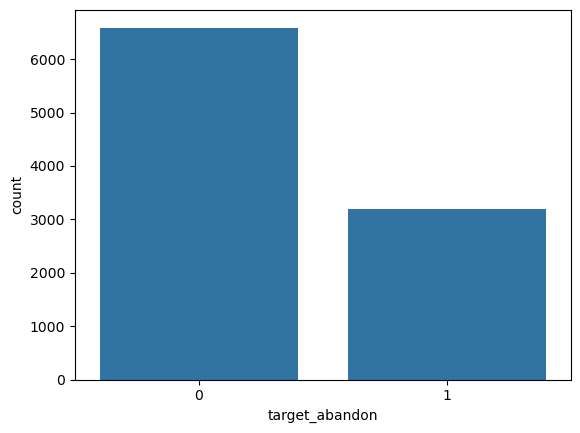

In [143]:
windows_with_ga3 = windows_with_ga2.copy()

# New abandon rate?
print(f"New abandonment rate is {windows_with_ga3['target_abandon'].mean():.4f}")

sns.countplot(data=windows_with_ga3, x='target_abandon')
plt.show()

In [144]:
windows_with_ga3.columns.isna().sum()

0

In [145]:
# Split the data
x = windows_with_ga3.drop(columns=['target_abandon'])
y = windows_with_ga3['target_abandon']

x = x.replace({pd.NA: np.nan})

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.2,
    random_state=12345,
    stratify=y  # keeps same balance of 0/1 in train and test
)



## Logistic model

In [146]:
# ===== 1) Convert time-like columns to human units (hours/days) =====
# Work on copies to avoid SettingWithCopy warnings
x_train = x_train.copy()
x_test  = x_test.copy()

# Timedelta -> HOURS
td_cols = x_train.select_dtypes(include=['timedelta64[ns]']).columns
for c in td_cols:
    x_train[c] = pd.to_timedelta(x_train[c], errors='coerce').dt.total_seconds() / 3600.0
    x_test[c]  = pd.to_timedelta(x_test[c],  errors='coerce').dt.total_seconds() / 3600.0

# Datetime -> DAYS since an anchor (min train date per column)
dt_cols = x_train.select_dtypes(include=['datetime64[ns]', 'datetime64[ns, UTC]']).columns
for c in dt_cols:
    tr = pd.to_datetime(x_train[c], errors='coerce')
    anchor = tr.min()
    x_train[c] = (pd.to_datetime(x_train[c], errors='coerce') - anchor).dt.total_seconds() / 86400.0
    x_test[c]  = (pd.to_datetime(x_test[c],  errors='coerce') - anchor).dt.total_seconds() / 86400.0

# ===== 2) Build simple pipeline (no standardization) =====
num_cols = x_train.select_dtypes(include=[np.number]).columns
cat_cols = x_train.select_dtypes(include=['object','category','bool']).columns

pipeline = Pipeline(steps=[
    ("prep", ColumnTransformer(transformers=[
        ("num", SimpleImputer(strategy="median"), num_cols),
        ("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("oh", OneHotEncoder(handle_unknown="ignore", drop="first"))
        ]), cat_cols),
    ])),
    # C > 1 reduces regularization -> easier-to-see coefficients
    ("clf", LogisticRegression(max_iter=1000, solver="liblinear", C=10.0))
])

# ===== 3) Fit & evaluate =====
pipeline.fit(x_train, y_train)

y_pred  = pipeline.predict(x_test)
y_proba = pipeline.predict_proba(x_test)[:, 1]

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))



Test Accuracy: 0.6739908022483393
Test AUC: 0.4975568077839914
              precision    recall  f1-score   support

           0       0.67      1.00      0.81      1319
           1       0.00      0.00      0.00       638

    accuracy                           0.67      1957
   macro avg       0.34      0.50      0.40      1957
weighted avg       0.45      0.67      0.54      1957



/opt/anaconda3/envs/msba/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/msba/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/envs/msba/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape

In [147]:
# ===== 4) Coefficients + Odds Ratios (interpretable) =====
pre = pipeline.named_steps["prep"]
clf = pipeline.named_steps["clf"]

# Feature names from ColumnTransformer (sklearn >= 1.0)
try:
    feature_names = pre.get_feature_names_out()
except AttributeError:
    # Fallback for older sklearn
    from sklearn.utils._metadata_requests import _safe_get_feature_names_out
    feature_names = _safe_get_feature_names_out(pre, input_features=x_train.columns)

coefs = clf.coef_[0]

coef_table = pd.DataFrame({
    "feature": feature_names,
    "coef": coefs,
})
coef_table["odds_ratio"] = np.exp(coef_table["coef"])             # per +1 unit
coef_table["odds_ratio_per_10"] = np.exp(10 * coef_table["coef"]) # per +10 units (helpful for time features)
coef_table["abs_coef"] = coef_table["coef"].abs()

# Sort by influence
coef_table = coef_table.sort_values("abs_coef", ascending=False)

# Pretty display
with pd.option_context('display.float_format', '{:.8f}'.format,
                       'display.max_rows', None,
                       'display.max_colwidth', 120):
    display(coef_table.head(30))



,feature,coef,odds_ratio,odds_ratio_per_10,abs_coef
0,num__CUSTOMER_ID,-0.00000000,1.00000000,0.99999999,0.00000000
8,num__last_event_time,-0.00000000,1.00000000,1.00000000,0.00000000
7,num__first_event_time,-0.00000000,1.00000000,1.00000000,0.00000000
2,num__WINDOW_END_LOCAL,-0.00000000,1.00000000,1.00000000,0.00000000
3,num__WINDOW_END_LOCAL_event_cutoff,-0.00000000,1.00000000,1.00000000,0.00000000
1,num__WINDOW_START_LOCAL,-0.00000000,1.00000000,1.00000000,0.00000000
9,num__duration_min_max_event,-0.00000000,1.00000000,1.00000000,0.00000000
4,num__WINDOW_FREQUENCY,-0.00000000,1.00000000,1.00000000,0.00000000
10,num__mode_event_day,-0.00000000,1.00000000,1.00000000,0.00000000
5,num__add_to_cart_count,0.00000000,1.00000000,1.00000000,0.00000000
